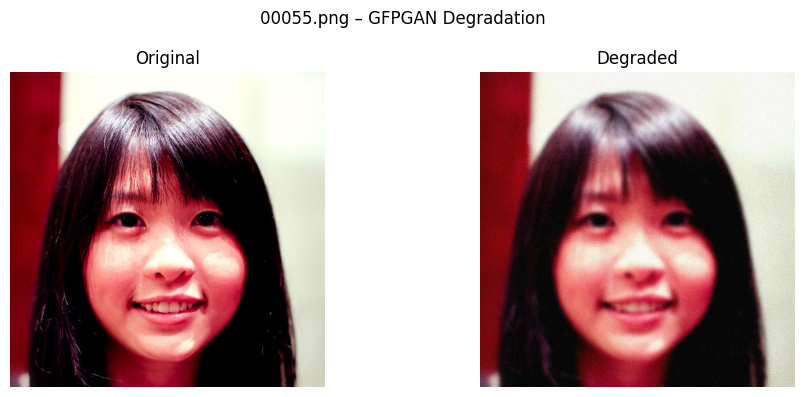

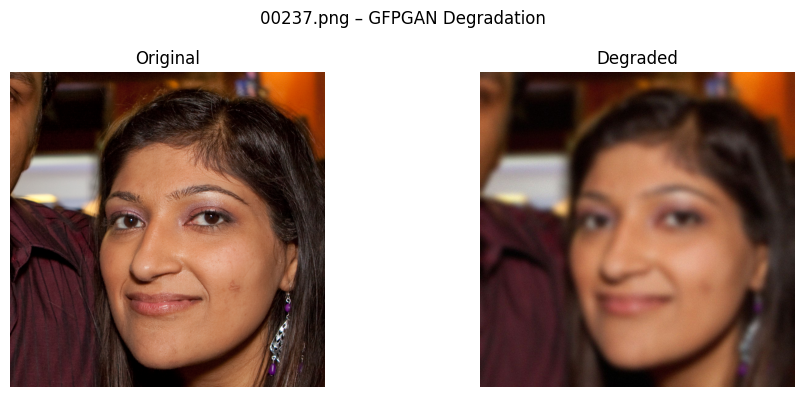

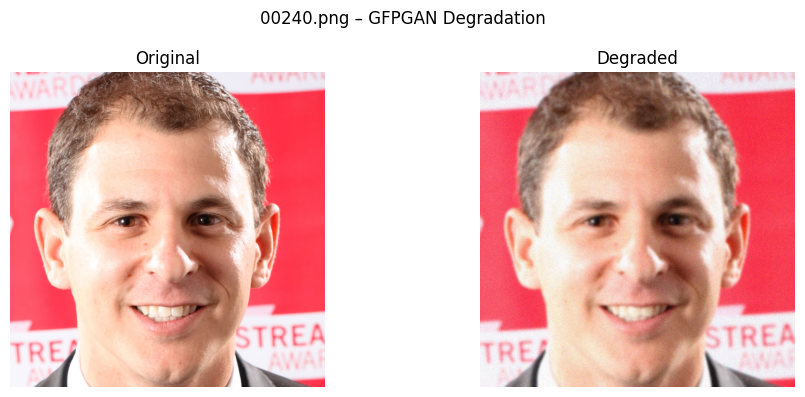

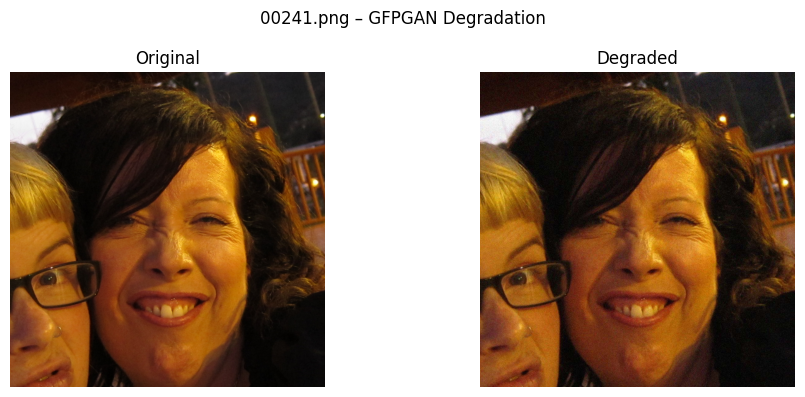

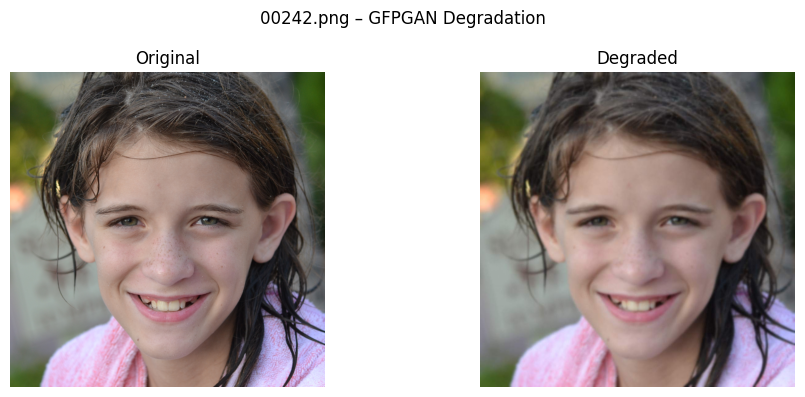

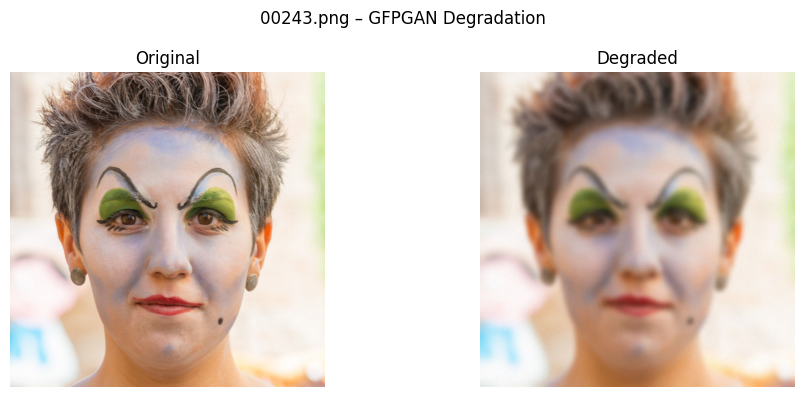

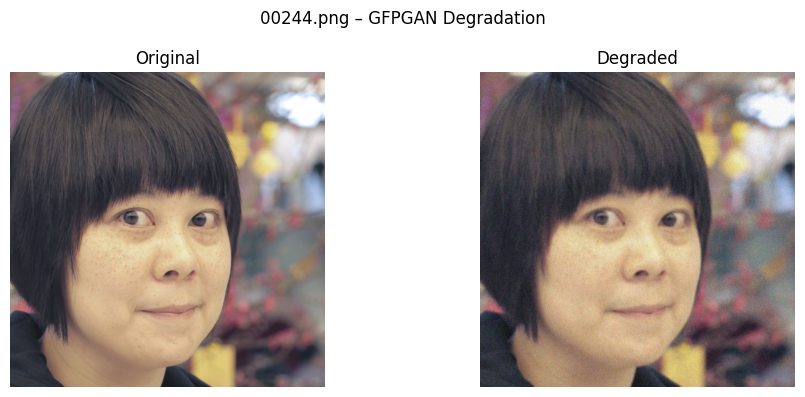

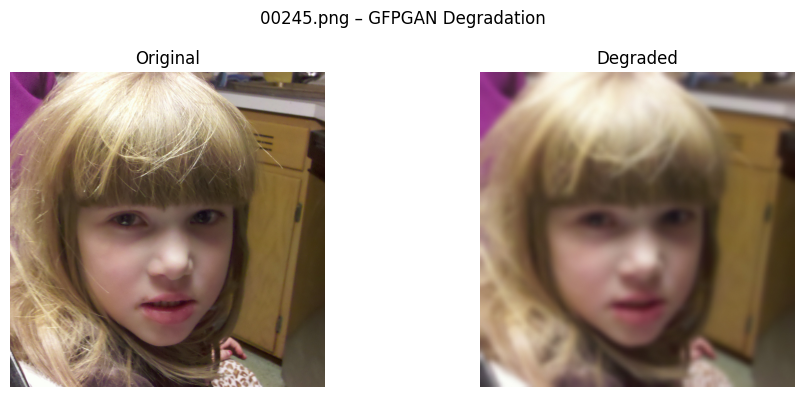

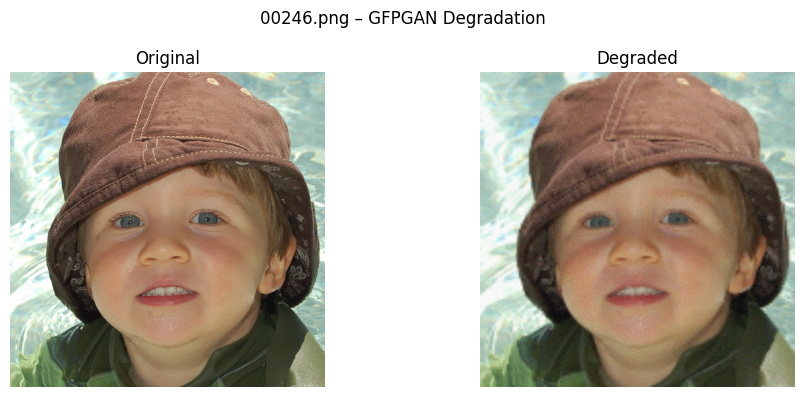

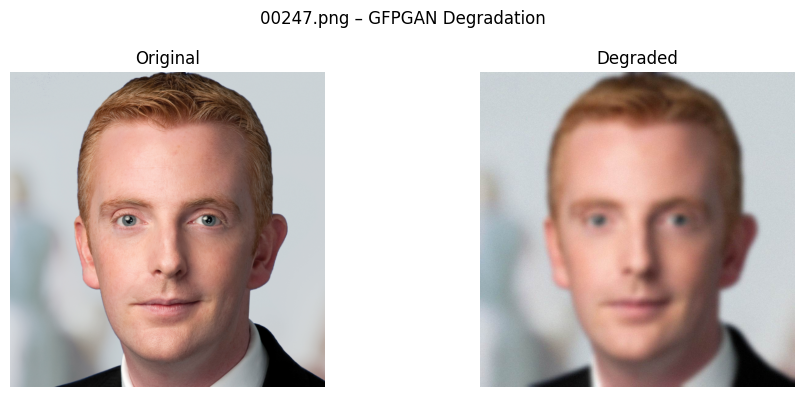

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# -------- Settings --------
mode = "gfpgan_original"  # applies settings from train_gfpgan_v1.yml
num_images = 10  # number of images to process

# -------- Paths --------
before_path = Path("/Users/rawanghanem_1/Desktop/GFPGAN/datasets/ffhq/results_before")
after_path = Path("/Users/rawanghanem_1/Desktop/GFPGAN/datasets/ffhq/results_after")
after_path.mkdir(parents=True, exist_ok=True)

# -------- GFPGAN-style Degradation Function --------
def degrade_image(img):
    h, w = img.shape[:2]

    # 1. Gaussian Blur
    blur_kernel_size = 41
    blur_sigma = random.uniform(0.1, 10)
    img = cv2.GaussianBlur(img, (blur_kernel_size, blur_kernel_size), sigmaX=blur_sigma)

    # 2. Downsampling and Upsampling
    downsample_ratio = random.uniform(0.8, 8.0)
    down_w, down_h = int(w / downsample_ratio), int(h / downsample_ratio)
    img = cv2.resize(img, (down_w, down_h), interpolation=cv2.INTER_LINEAR)
    img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)

    # 3. Gaussian Noise
    noise_level = random.uniform(0, 20)
    noise = np.random.normal(0, noise_level, img.shape).astype(np.float32)
    img = np.clip(img + noise, 0, 255).astype(np.uint8)

    # 4. JPEG Compression
    jpeg_quality = random.randint(60, 100)
    _, enc_img = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality])
    img = cv2.imdecode(enc_img, 1)

    return img

# -------- Process and Display --------
image_files = list(before_path.glob("*.png")) + list(before_path.glob("*.jpg"))
sample_files = sorted(image_files)[:num_images]

for img_path in sample_files:
    img_name = img_path.name
    img = cv2.imread(str(img_path))

    if img is None:
        continue

    # Apply degradation
    degraded_img = degrade_image(img)

    # Save degraded image
    save_path = after_path / img_name
    cv2.imwrite(str(save_path), degraded_img)

    # Convert to RGB for display
    original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    degraded_rgb = cv2.cvtColor(degraded_img, cv2.COLOR_BGR2RGB)

    # Show side-by-side comparison
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(degraded_rgb)
    plt.title("Degraded")
    plt.axis("off")

    plt.suptitle(f"{img_name} – GFPGAN Degradation", fontsize=12)
    plt.tight_layout()
    plt.show()


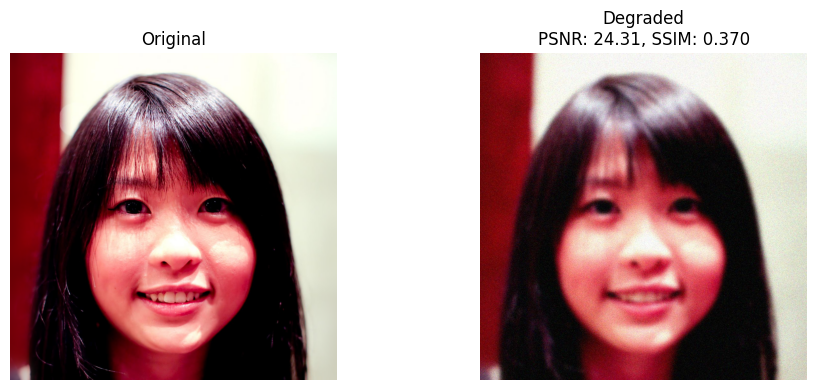

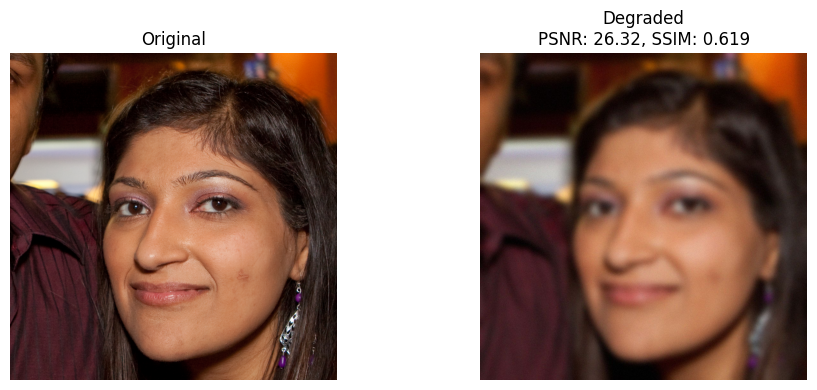

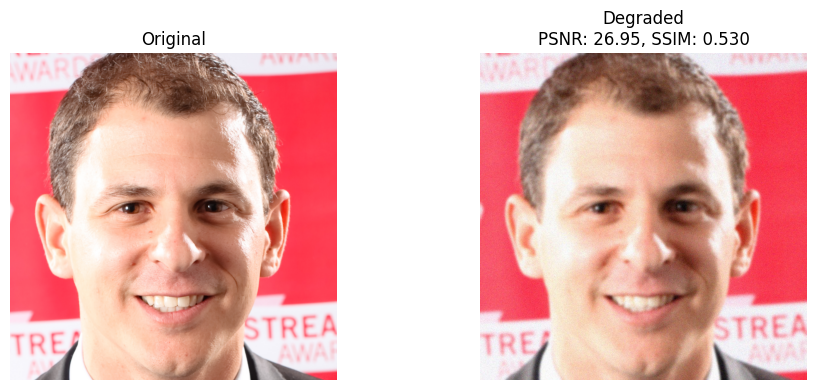

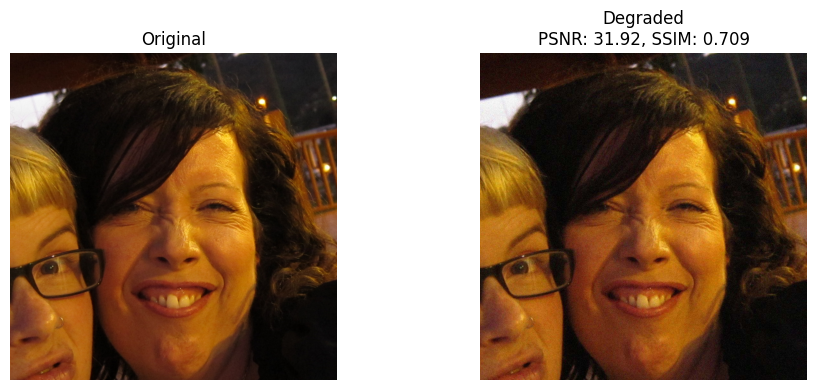

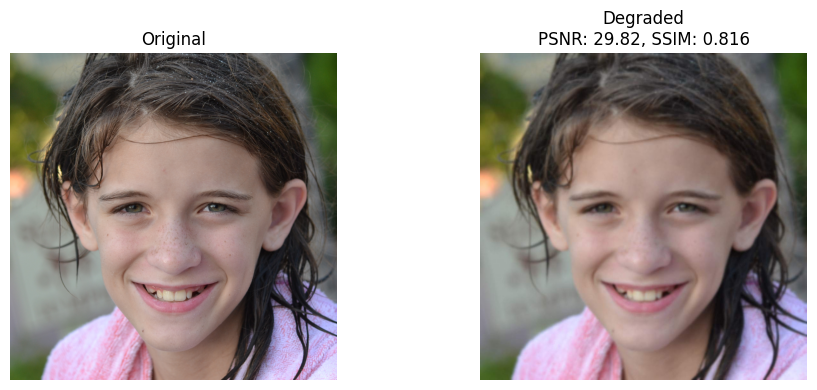

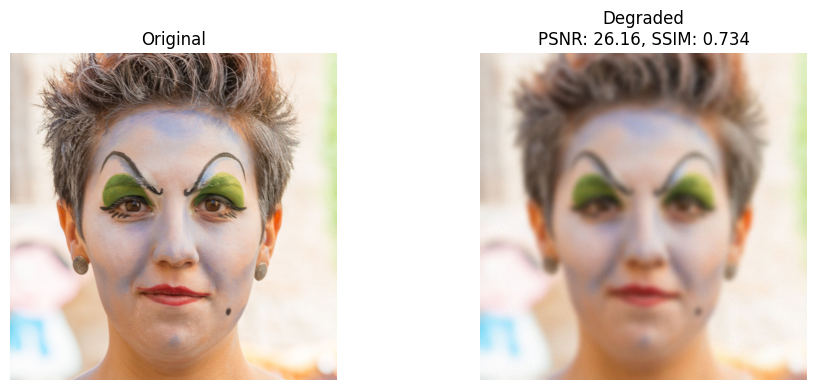

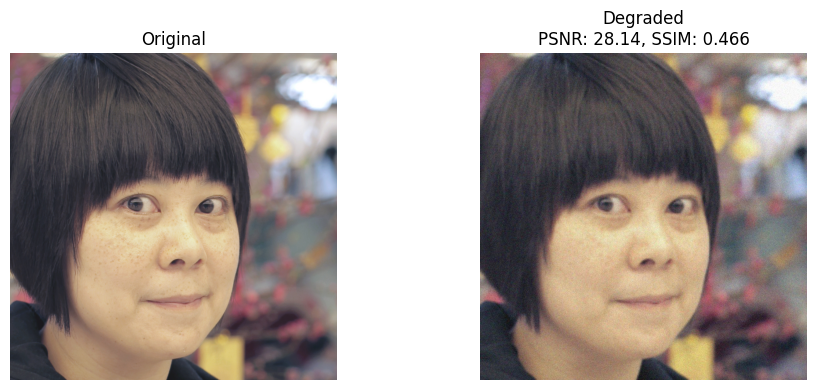

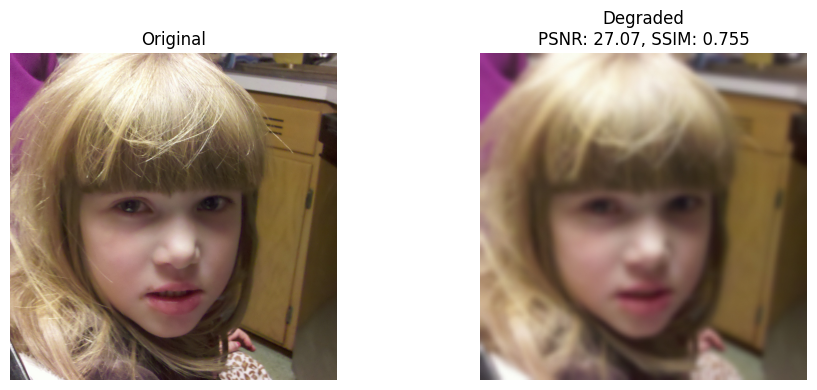

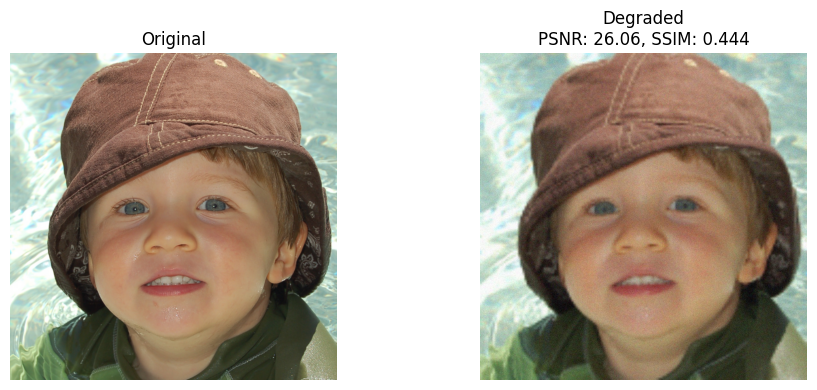

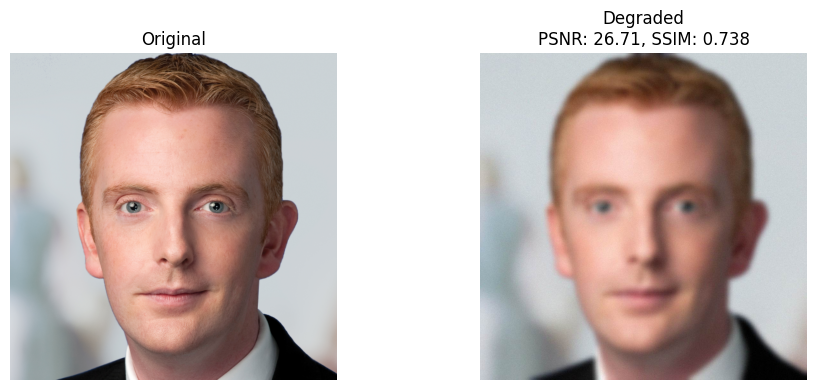

📊 Average PSNR over 10 images: 27.35 dB
📊 Average SSIM over 10 images: 0.618


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# --- Paths to images ---
before_path = Path("/Users/rawanghanem_1/Desktop/GFPGAN/datasets/ffhq/results_before")
after_path = Path("/Users/rawanghanem_1/Desktop/GFPGAN/datasets/ffhq/results_after")

# --- Collect image names ---
image_names = sorted([f.name for f in before_path.glob("*.png") if (after_path / f.name).exists()])[:10]

# --- Store scores ---
psnr_scores = []
ssim_scores = []

# --- Loop over each image pair ---
for name in image_names:
    original = cv2.imread(str(before_path / name))
    degraded = cv2.imread(str(after_path / name))

    if original is None or degraded is None:
        continue

    # Convert to grayscale
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    degraded_gray = cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)

    # Calculate metrics
    score_psnr = psnr(original_gray, degraded_gray)
    score_ssim = ssim(original_gray, degraded_gray)

    psnr_scores.append(score_psnr)
    ssim_scores.append(score_ssim)

    # Show images side by side
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    degraded_rgb = cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(degraded_rgb)
    plt.title(f"Degraded\nPSNR: {score_psnr:.2f}, SSIM: {score_ssim:.3f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# --- Print average scores ---
print(f" Average PSNR over 10 images: {np.mean(psnr_scores):.2f} dB")
print(f" Average SSIM over 10 images: {np.mean(ssim_scores):.3f}")
'''
| Metric | Range  | Goal             | Meaning if High     |
| ------ | ------ | --------------   | ------------------- |
| PSNR | 0 → ∞ dB | Higher is better | Low pixel error     |
| SSIM | 0 → 1    | Closer to 1      | Structure preserved |
'''


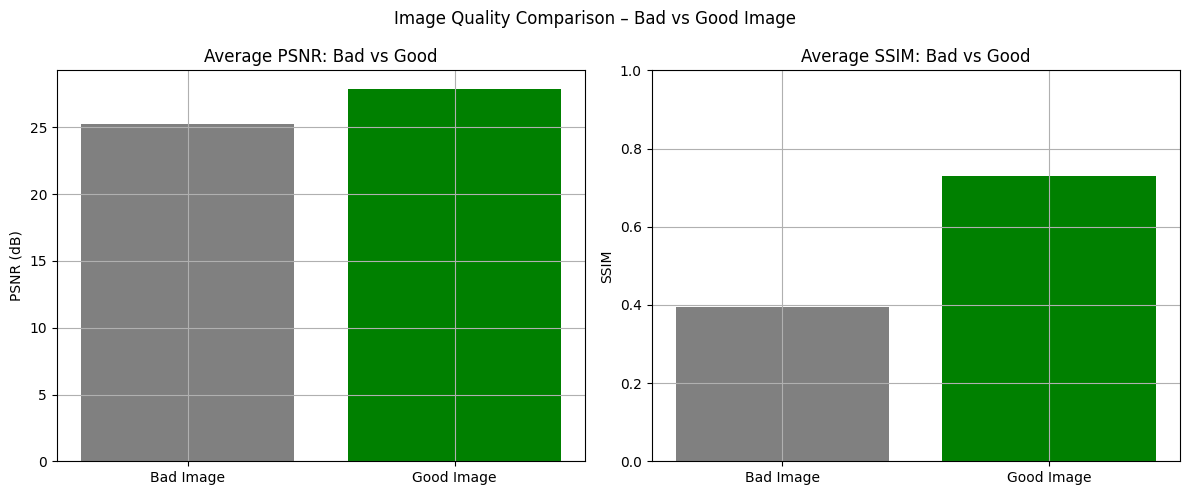

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from pathlib import Path
import random

# Load images
before_path = Path("/Users/rawanghanem_1/Desktop/GFPGAN/datasets/ffhq/results_before")
image_files = sorted(list(before_path.glob("*.png")) + list(before_path.glob("*.jpg")))[:500]

# Lists to store results
psnr_bad = []
psnr_good = []
ssim_bad = []
ssim_good = []

# Degradation (to simulate Bad Image)
def degrade_image(img, h, w):
    img = cv2.GaussianBlur(img, (41, 41), sigmaX=random.uniform(0.1, 10))
    scale = random.uniform(2.0, 4.0)
    img = cv2.resize(img, (int(w / scale), int(h / scale)))
    img = cv2.resize(img, (w, h))
    noise = np.random.normal(0, 15, img.shape).astype(np.float32)
    img = np.clip(img + noise, 0, 255).astype(np.uint8)
    _, enc = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
    return cv2.imdecode(enc, 1)

# Process each image
for img_path in image_files:
    original = cv2.imread(str(img_path))
    if original is None: continue
    h, w = original.shape[:2]

    bad_img = degrade_image(original.copy(), h, w)
    good_img = cv2.fastNlMeansDenoisingColored(bad_img, None, 10, 10, 7, 21)

    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    bad_gray = cv2.cvtColor(bad_img, cv2.COLOR_BGR2GRAY)
    good_gray = cv2.cvtColor(good_img, cv2.COLOR_BGR2GRAY)

    psnr_bad.append(psnr(original_gray, bad_gray))
    psnr_good.append(psnr(original_gray, good_gray))
    ssim_bad.append(ssim(original_gray, bad_gray))
    ssim_good.append(ssim(original_gray, good_gray))

# Plot average PSNR & SSIM
labels = ['Bad Image', 'Good Image']
avg_psnr = [np.mean(psnr_bad), np.mean(psnr_good)]
avg_ssim = [np.mean(ssim_bad), np.mean(ssim_good)]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(labels, avg_psnr, color=['gray', 'green'])
axs[0].set_title("Average PSNR: Bad vs Good")
axs[0].set_ylabel("PSNR (dB)")
axs[0].grid(True)

axs[1].bar(labels, avg_ssim, color=['gray', 'green'])
axs[1].set_title("Average SSIM: Bad vs Good")
axs[1].set_ylabel("SSIM")
axs[1].set_ylim(0, 1)
axs[1].grid(True)

plt.suptitle("Image Quality Comparison – Bad vs Good Image")
plt.tight_layout()
plt.show()
